# Clustering 2 - Ouray County Parcel Risk
**Author:** Bryce A Young  
**Created:** 2025-04-08 | 
**Modified:** 2025-04-08  

#### Overview
This notebook is largely a revision of the analysis performed in `clustering.ipynb`. 

In this notebook, I do four things: 
1. Import data on the 4000+ homes in Ouray County for which I have both LiDAR and tax assessor data. I select and clean the features with classification and one-hot encoding.
2. Use t-SNE to reduce the dimensionality of the dataset to two dimensions, modifying hyperparameters to get clusters to appear while revealing data relationships.
3. Use DBSCAN to cluster home types based on structure and defensible space features that relate both to *susceptibility* and *heat and ember outputs*.
4. Analyze the clusters for the salient features of structure and DSpace archetypes.

*NOTE: Clustering effectively groups homes into archetypes, then we can go back and assign archetypes to homes and assess how many of those homes burned in historic fires such as Palisades, Eaton, Lahaina, Marshall, and Camp.*

## Environment Setup
---

In [1]:
# setup environment
import os
### Directory ###
# Repository
os.chdir(r'D:/_PROJECTS/P001_OurayParcel/ouray')
# Root workspace
ws = r'D:/_PROJECTS/P001_OurayParcel'

### Data paths ###
# Folder where all the data inputs and outputs will live
data = os.path.join(ws, 'data')
# Scratch folder for intermediate files
scratch = os.path.join(data, '_temp')
# Any final data outputs go here
out = os.path.join(data, '_out')
# Figures to export
figs = os.path.join(ws, r'output/figures')

# correct working directory
os.getcwd()

'D:\\_PROJECTS\\P001_OurayParcel\\ouray'

## Import data
---

In [2]:
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', None) # Display all columns when previewing dfs

gdf = gpd.read_file(os.path.join(out, 'centr_full_nonan_WKID26913.gpkg'))
# df = gdf.drop(columns='geometry')

gdf.head()

,County,wui_class,min_ssd,mean_cc0_2m,mean_cc2_4m,mean_cc4_8m,mean_cc8_40m,intersections,PARCELNB,ACCOUNT,ACRES_calc,hiz_ext_out,Actual Year Built\n(AYB),Air Conditioning\n(AIRC),Architecture Style\n(ARCH),Area Acres\n(Area_ACRES),Area SQFT\n(Area_SQFT),Condition\n(COND),DGR - Detached Garage\n(SubArea_DGR),Effective Year Built\n(EYB),Exterior Percent\n(EXW_PERCENT),Exterior Wall\n(EXW),Floor\n(FLR),Frame\n(FRME),Heating Fuel\n(HTFL),Interior Wall\n(INT),Neighborhood\n(NBHD),OPP - Open Porch\n(SubArea_OPP),PTO - Patio\n(SubArea_PTO),RMS\n(RMS),Roof Cover\n(RCVR),Roof Structure\n(RSTR),Type,WBL - Wood Balcony\n(SubArea_WBL),geometry
0,Ouray County,5,11.936200,0.079294,0.119998,0.066202,0.003467,2,403726200085,R002417,35.8913,False,1999.0,0 - N/A,1 - RANCH,0.0,2006.0,3 - GOOD,0.0,2005.0,100.0,9 - MASONITE,1 - WDJST PLYW,9 - FRME 2X4,7 - PROPANE,1 - DRYWALL,7000006 - Outlying6,0.0,577.5,0.776148,9 - PRO PANEL,3 - SHED MED,Residence,0.0,POINT (242785.257 4243534.402)
1,Ouray County,1,213.672097,0.032280,0.038839,0.006272,0.000000,0,403915300016,R004080,40.1202,False,2009.0,0 - N/A,1 - RANCH,0.0,1725.0,2 - VERY GOOD,0.0,2010.0,90.0,5 - STUCCO (F),4 - CONC/TILE,9 - FRME 2X4,3 - GAS,1 - DRYWALL,7000006 - Outlying6,560.0,0.0,0.776148,3 - DISTRESSED METAL,6 - GABEL MED,Residence,0.0,POINT (251212.196 4245423.292)
2,Ouray County,5,183.675975,0.063696,0.097281,0.033223,0.082861,0,403736200037,R002506,39.7779,False,1996.0,0 - N/A,7 - MTN CABIN,0.0,692.6,3 - GOOD,0.0,2005.0,100.0,2 - WOOD,5 - CONCRETE,0 - N/A,2 - WOOD,1 - DRYWALL,7000006 - Outlying6,0.0,0.0,0.000000,5 - ASPH SHNGL,3 - SHED MED,Residence,0.0,POINT (244097.801 4241432.894)
3,Ouray County,5,101.386718,0.037428,0.219677,0.253634,0.000842,0,403925218002,R004877,16.5952,True,2004.0,0 - N/A,5 - MODULAR,0.0,894.0,3 - GOOD,0.0,2010.0,100.0,9 - MASONITE,1 - WDJST PLYW,9 - FRME 2X4,7 - PROPANE,1 - DRYWALL,7000006 - Outlying6,179.0,0.0,0.776148,9 - PRO PANEL,6 - GABEL MED,Residence,0.0,POINT (254078.896 4242776.879)
4,Ouray County,3,20.213243,0.056646,0.058065,0.112239,0.181261,2,404129300015,R004133,398.9760,False,1958.0,1 - NONE,1 - RANCH,0.0,1262.0,3 - GOOD,0.0,1995.0,100.0,9 - MASONITE,1 - WDJST PLYW,9 - FRME 2X4,7 - PROPANE,3 - PANELING,7000002 - Outlying2,0.0,0.0,0.000000,9 - PRO PANEL,6 - GABEL MED,Residence,0.0,POINT (257784.354 4241777.874)


In [3]:
# Create index col for future reference
gdf['index'] = gdf.index
# df['index'] = df.index

## Feature Selection
---
`wui_class` was dropped because of its correlation with LiDAR metrics. Others were dropped because of the lack of information in the data or because of low evidence of the feature being correlated with structure loss or fire behavior.

In [4]:
# Drop unwanted cols
cols2drop = [
    'wui_class',
    'County',
    'Actual Year Built\n(AYB)',
    'Air Conditioning\n(AIRC)',
    'Architecture Style\n(ARCH)',
    'Effective Year Built\n(EYB)',
    'Exterior Percent\n(EXW_PERCENT)',
    'Floor\n(FLR)',
    'Frame\n(FRME)',
    'Interior Wall\n(INT)',
    'Neighborhood\n(NBHD)',
    'RMS\n(RMS)'
]

gdf.drop(columns=cols2drop, inplace=True)
gdf.columns

Index(['min_ssd', 'mean_cc0_2m', 'mean_cc2_4m', 'mean_cc4_8m', 'mean_cc8_40m',
       'intersections', 'PARCELNB', 'ACCOUNT', 'ACRES_calc', 'hiz_ext_out',
       'Area Acres\n(Area_ACRES)', 'Area SQFT\n(Area_SQFT)',
       'Condition\n(COND)', 'DGR - Detached Garage\n(SubArea_DGR)',
       'Exterior Wall\n(EXW)', 'Heating Fuel\n(HTFL)',
       'OPP - Open Porch\n(SubArea_OPP)', 'PTO - Patio\n(SubArea_PTO)',
       'Roof Cover\n(RCVR)', 'Roof Structure\n(RSTR)', 'Type',
       'WBL - Wood Balcony\n(SubArea_WBL)', 'geometry', 'index'],
      dtype='object')

## Feature Transformations
---
Features are transformed to have minimal noise. Most columns are binary based on some class or threshold evident in the literature. Some columns are classified with minimal classes based on evidence in the literature, and because t-SNE performs best with skewed distributions in 2 classes.

In [6]:
# Create boolean col for presence of porch, patio, wood balcony
gdf['porch_balcony'] = (
    (gdf['OPP - Open Porch\n(SubArea_OPP)'] > 0) |
    (gdf['PTO - Patio\n(SubArea_PTO)'] > 0) |
    (gdf['WBL - Wood Balcony\n(SubArea_WBL)'] > 0)
).fillna(0).astype(int)

# Create boolean col for presence of detached garage
gdf['detached_garage'] = (
    gdf['DGR - Detached Garage\n(SubArea_DGR)'] > 0
).fillna(0).astype(int)

# Create boolean col for avg or below home condition
gdf['cond_below_avg'] = gdf['Condition\n(COND)'].isin([
    '4 - AVERAGE', 
    '5 - BELOW AVERAGE', 
    '6 - POOR'
    ]).fillna(0).astype(int)

# Create boolean col for wood stove
gdf['wood_stove'] = gdf['Heating Fuel\n(HTFL)'].isin(['2 - WOOD']).fillna(0).astype(int)

# Create class col for sqft
bins = [0, 1500, 3000, 5000, float('inf')]
labels = [1, 2, 3, 4]
gdf['home_sqft'] = pd.cut(
    gdf['Area SQFT\n(Area_SQFT)'],
    bins=bins,
    labels=labels,
    include_lowest=True
).astype(int)

# Create boolean col for wood siding
gdf['wood_exw'] = gdf['Exterior Wall\n(EXW)'].isin([
    '2 - WOOD',
    '16 - REAL LOG',
    '21 - MILLED LOG',
    '24 - CEDAR',
    '8 - MISC. WOOD',
    '15 - PLYWOOD',
    '25 - T&G PINE',
    '10 - WD SHINGLE',
    '1 - CEDAR'
    ]).fillna(0).astype(int)

# Create boolean col for wood roof
gdf['wood_roof'] = gdf['Roof Cover\n(RCVR)'].isin([
    '6 - WOOD SHINGLE',
    '2 - CEDAR SHAKE',
    '3 - SHAKE SHGL'
]).fillna(0).astype(int)

# Create boolean col for multi-peak roof
gdf['roofstr_multipeak'] = gdf['Roof Structure\n(RSTR)'].isin(['8 - MULTI PEAK']).fillna(0).astype(int)

# Create class col for property acres
acre_bins = [0, 1, 3, 5, 10, 100, float('inf')]
acre_labels = [1, 2, 3, 4, 5, 6]
gdf['property_acres'] = pd.cut(
    gdf['ACRES_calc'],
    bins=acre_bins,
    labels=acre_labels,
    include_lowest=True
).astype(int)

# Create class col for SSD
ssd_bins = [0, 10, 30, float('inf')]
ssd_labels = [1, 2, 3]
gdf['ssd_class'] = pd.cut(
    gdf['min_ssd'],
    bins=ssd_bins,
    labels=ssd_labels,
    include_lowest=True
).astype(int)

# Create binary col for 2+ intersections
gdf['intsc>2'] = (gdf['intersections'] >= 2).fillna(0).astype(int)

# Create class cols for fuel cover
cc_bins = [-0.01, 0.1, 0.3, float('inf')]
cc_labels = [1, 2, 3]
for col in ['mean_cc0_2m', 'mean_cc2_4m', 'mean_cc4_8m', 'mean_cc8_40m']:
    new_col = col.replace('mean_c', 'class_f')
    gdf[new_col] = pd.cut(gdf[col], bins=cc_bins, labels=cc_labels).astype(int)

# Create binary col for fuel cover >0.6
gdf['cc_sum'] = (
    gdf['mean_cc0_2m'].fillna(0) +
    gdf['mean_cc2_4m'].fillna(0) +
    gdf['mean_cc4_8m'].fillna(0) +
    gdf['mean_cc8_40m'].fillna(0)
)
gdf['total_fc>60%'] = (gdf['cc_sum'] >= 0.6).astype(int)

# Drop cols for which new cols were made above
gdf.drop(columns=[
    'OPP - Open Porch\n(SubArea_OPP)',
    'PTO - Patio\n(SubArea_PTO)',
    'WBL - Wood Balcony\n(SubArea_WBL)',
    'Condition\n(COND)',
    'DGR - Detached Garage\n(SubArea_DGR)',
    'Heating Fuel\n(HTFL)',
    'Area SQFT\n(Area_SQFT)',
    'Exterior Wall\n(EXW)',
    'Roof Cover\n(RCVR)',
    'Roof Structure\n(RSTR)',
    'ACRES_calc',
    'Area Acres\n(Area_ACRES)',
    'min_ssd',
    'intersections',
    'mean_cc0_2m', 
    'mean_cc2_4m', 
    'mean_cc4_8m', 
    'mean_cc8_40m',
    'cc_sum'
], inplace=True)

In [7]:
# Save these as cluster columns
cluster_cols = [
    'porch_balcony',
    'detached_garage',
    'cond_below_avg',
    'wood_stove',
    'home_sqft',
    'wood_exw',
    'wood_roof',
    'roofstr_multipeak',
    'property_acres',
    'ssd_class',
    'intsc>2',
    'class_fc0_2m',
    'class_fc2_4m',
    'class_fc4_8m',
    'class_fc8_40m',
    'total_fc>60%',
    'index' # Keep index col to merge df and gdf later
]

## Dimensionality Reduction with t-SNE
---
### All features

In [8]:
# Separate cluster cols
df = gdf[cluster_cols].copy()

# Save X for tsne, dropping index
X = df.drop(columns='index')

In [9]:
for col in X:
    value_counts = X[col].value_counts()  # Get counts per unique value
    print(f"\nFeature: {col}")
    print(value_counts.to_string())  # Print in a clean format


Feature: porch_balcony
porch_balcony
1    3126
0     876

Feature: detached_garage
detached_garage
0    3573
1     429

Feature: cond_below_avg
cond_below_avg
0    3876
1     126

Feature: wood_stove
wood_stove
0    3613
1     389

Feature: home_sqft
home_sqft
2    2048
1    1056
3     673
4     225

Feature: wood_exw
wood_exw
1    2045
0    1957

Feature: wood_roof
wood_roof
0    3801
1     201

Feature: roofstr_multipeak
roofstr_multipeak
0    3759
1     243

Feature: property_acres
property_acres
1    1285
5    1141
2     556
6     411
4     318
3     291

Feature: ssd_class
ssd_class
1    1437
3    1408
2    1157

Feature: intsc>2
intsc>2
0    2532
1    1470

Feature: class_fc0_2m
class_fc0_2m
1    3466
2     532
3       4

Feature: class_fc2_4m
class_fc2_4m
1    2353
2    1612
3      37

Feature: class_fc4_8m
class_fc4_8m
2    1977
1    1844
3     181

Feature: class_fc8_40m
class_fc8_40m
1    2721
2    1113
3     168

Feature: total_fc>60%
total_fc>60%
0    3675
1     327


In [10]:
print(f'there are {len(cluster_cols) - 1} predictive features')
print(f'there are {len(df)} total structures')

there are 16 predictive features
there are 4002 total structures


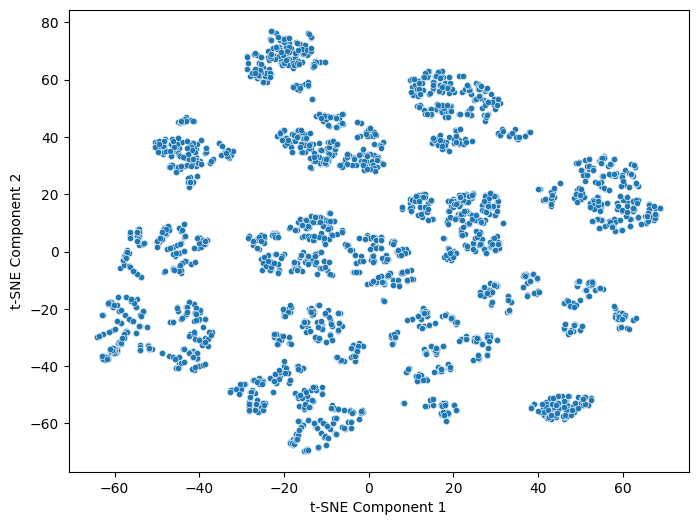

In [11]:
# Scale features
from sklearn.preprocessing import StandardScaler

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##################################
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=38, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Convert to DataFrame, adding index col for future merge
df_tsne = pd.DataFrame({
    'index': df['index'].values,
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1]
})

# Visualize t-SNE
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_tsne['TSNE1'], y=df_tsne['TSNE2'], s=20)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
# plt.title("t-SNE Projection: perplexity=38")
plt.grid(False)
plt.show()

### DSpace Features

In [49]:
# Separate HIZ features
hiz_cols = [
    'detached_garage',
    'wood_stove',
    'property_acres',
    'ssd_class',
    'intsc>2',
    'class_fc0_2m',
    'class_fc2_4m',
    'class_fc4_8m',
    'class_fc8_40m',
    'total_fc>60%',
    'index'
]

hiz_df = gdf[hiz_cols].copy()
X = hiz_df.drop(columns='index')

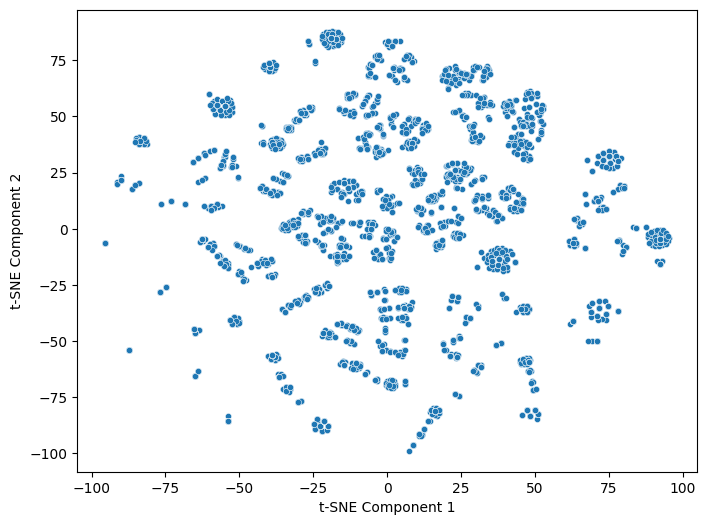

In [ ]:
# Scale features
from sklearn.preprocessing import StandardScaler

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##################################
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Convert to DataFrame, adding index col for future merge
df_tsne_hiz = pd.DataFrame({
    'index': hiz_df['index'].values,
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1]
})

# Visualize t-SNE
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_tsne_hiz['TSNE1'], y=df_tsne_hiz['TSNE2'], s=20)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(False)
plt.show()

### Structure Features

In [55]:
# Separate structure features
str_cols = [
    'porch_balcony',
    'cond_below_avg',
    'wood_stove',
    'home_sqft',
    'wood_exw',
    'wood_roof',
    'roofstr_multipeak',
    'index'
]

str_df = gdf[str_cols].copy()
X = str_df.drop(columns='index')

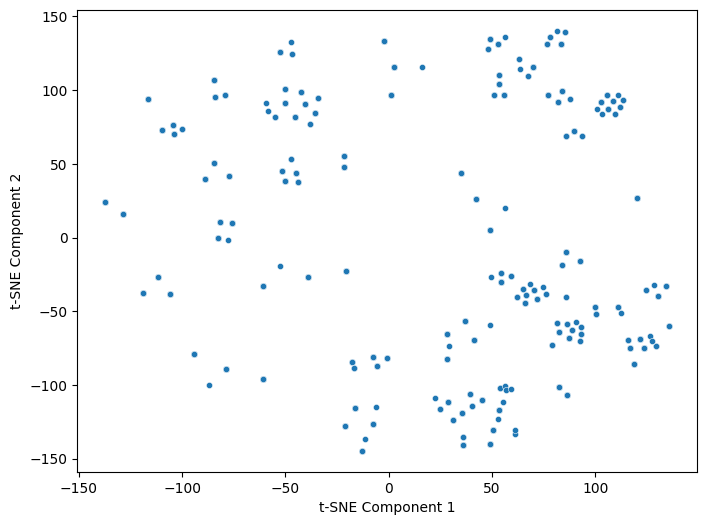

In [58]:
# Scale features
from sklearn.preprocessing import StandardScaler

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##################################
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Convert to DataFrame, adding index col for future merge
df_tsne_str = pd.DataFrame({
    'index': str_df['index'].values,
    'TSNE1': X_tsne[:, 0],
    'TSNE2': X_tsne[:, 1]
})

# Visualize t-SNE
plt.figure(figsize=(8,6))
sns.scatterplot(x=df_tsne_str['TSNE1'], y=df_tsne_str['TSNE2'], s=20)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(False)
plt.show()

## Clustering with DBSCAN
---

In [19]:
from sklearn.cluster import DBSCAN
import numpy as np

# Define DBSCAN parameters
eps = 5.5  # Adjust iteratively
min_samples = 100  # Minimum points to form a dense cluster

# Run DBSCAN on t-SNE data
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
df['cluster_dbscan'] = dbscan.fit_predict(X_tsne)  # Assign clusters

# Print unique cluster labels
print(f"DBSCAN found {df['cluster_dbscan'].nunique()} clusters (including noise)")

DBSCAN found 5 clusters (including noise)


C:\Users\User\AppData\Local\Temp\ipykernel_21676\4217324094.py:5: UserWarning: The palette list has more values (39) than needed (5), which may not be intended.
  sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['cluster_dbscan'], palette=sns.color_palette(n_colors=39))


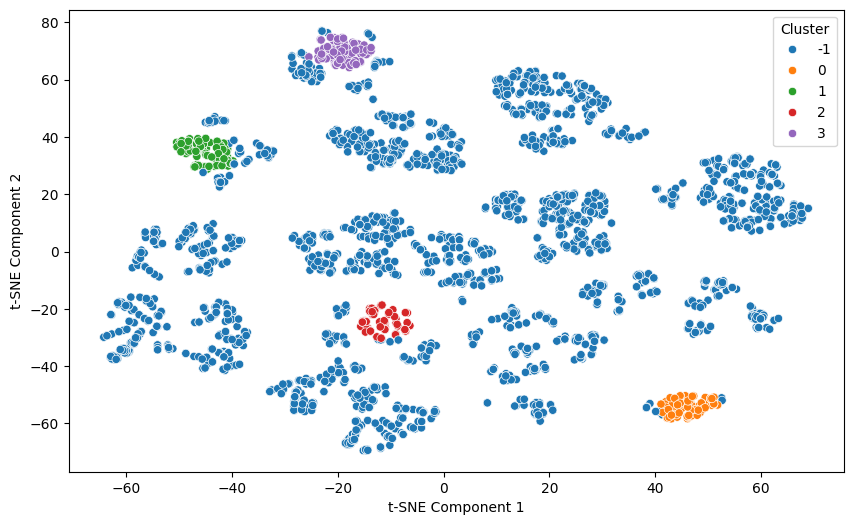

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df['cluster_dbscan'], palette=sns.color_palette(n_colors=39))
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
# plt.title("DBSCAN Clustering on t-SNE Data (eps=3.5, min_samples=15)")
plt.legend(title="Cluster")
plt.show()

In [21]:
# Group by DBSCAN clusters and compute mean values for features
cluster_summary = df.groupby('cluster_dbscan')[cluster_cols].describe()
cluster_summary

porch_balcony                                               \
                       count      mean       std  min  25%  50%  75%  max   
cluster_dbscan                                                              
-1                    3528.0  0.776644  0.416554  0.0  1.0  1.0  1.0  1.0   
 0                     113.0  0.433628  0.497783  0.0  0.0  0.0  1.0  1.0   
 1                     125.0  0.832000  0.375371  0.0  1.0  1.0  1.0  1.0   
 2                     111.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0   
 3                     125.0  0.976000  0.153665  0.0  1.0  1.0  1.0  1.0   

               detached_garage                                               \
                         count      mean       std  min  25%  50%  75%  max   
cluster_dbscan                                                                
-1                      3528.0  0.121599  0.326868  0.0  0.0  0.0  0.0  1.0   
 0                       113.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
 1                       125.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
 2                       111.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
 3                       125.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   

               cond_below_avg                                               \
                        count      mean       std  min  25%  50%  75%  max   
cluster_dbscan                                                               
-1                     3528.0  0.003685  0.060599  0.0  0.0  0.0  0.0  1.0   
 0                      113.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0   
 1                      125.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
 2                      111.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
 3                      125.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   

               wood_stove                                               \
                    count      mean       std  min  25%  50%  75%  max   
cluster_dbscan                                                           
-1                 3528.0  0.109410  0.312198  0.0  0.0  0.0  0.0  1.0   
 0                  113.0  0.026549  0.161476  0.0  0.0  0.0  0.0  1.0   
 1                  125.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
 2                  111.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
 3                  125.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   

               home_sqft                                               \
                   count      mean       std  min  25%  50%  75%  max   
cluster_dbscan                                                          
-1                3528.0  1.950964  0.768407  1.0  1.0  2.0  2.0  4.0   
 0                 113.0  2.000000  1.101946  1.0  1.0  2.0  2.0  4.0   
 1                 125.0  2.800000  0.879883  1.0  2.0  3.0  3.0  4.0   
 2                 111.0  2.396396  0.691234  1.0  2.0  2.0  3.0  4.0   
 3                 125.0  2.768000  0.814545  1.0  2.0  3.0  3.0  4.0   

               wood_exw                                               \
                  count      mean       std  min  25%  50%  75%  max   
cluster_dbscan                                                         
-1               3528.0  0.491780  0.500003  0.0  0.0  0.0  1.0  1.0   
 0                113.0  0.256637  0.438723  0.0  0.0  0.0  1.0  1.0   
 1                125.0  0.824000  0.382353  0.0  1.0  1.0  1.0  1.0   
 2                111.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0   
 3                125.0  0.536000  0.500709  0.0  0.0  1.0  1.0  1.0   

               wood_roof                                               \
                   count      mean       std  min  25%  50%  75%  max   
cluster_dbscan                                                          
-1                3528.0  0.021542  0.145203  0.0  0.0  0.0  0.0  1.0   
 0                 113.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
 1                 1